# Predicting Lego Set Prices
As new lego sets approach release, there are rumors and leaks, sometimes containing all of the details of the set.
The objective of this model is to be able to predict as accurately as possible, from the available information what hte price of these sets is going to be.

In [1]:
#Imports
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import BinaryEncoder
print('imported')

imported


Here we import the data generated from the LegoEDA project.

In [2]:
#read in clean data
lego_mod_df = pd.read_csv('legoData_mod.csv')
lego_mod_df.head


<bound method NDFrame.head of       Unnamed: 0 Set_number                       Name Set_type       Theme  \
0            212      702-2            Small Basic Set   Normal   SAMSONITE   
1            217      717-1         Junior Constructor   Normal   SAMSONITE   
2            218      725-3                  Town Plan   Normal   SAMSONITE   
3            279      450-2        Deluxe Building Set   Normal   SAMSONITE   
4            281      615-1         Samsonite Gift Set   Normal   SAMSONITE   
...          ...        ...                        ...      ...         ...   
6787       19108    80043-1       Yellow Tusk Elephant   Normal  MONKIE KID   
6788       19109    80044-1  Monkie Kid's Team Hideout   Normal  MONKIE KID   
6789       19110    80045-1     Monkey King Ultra Mech   Normal  MONKIE KID   
6790       19111    80110-1     Lunar New Year Display   Normal    SEASONAL   
6791       19112    80111-1      Lunar New Year Parade   Normal    SEASONAL   

           Theme_grou

Just a reminder of what the data looks like

In [3]:
#Numerical features, without Price, which is our target variable
lego_num_cols=['Year_released', 'Pieces', 'Minifigs']
#Categorical features
lego_cat_cols=['Set_number', 'Name', 'Set_type', 'Theme', 'Theme_group', 'Subtheme', 'Age_range']
lego_num = lego_mod_df[lego_num_cols]
lego_cat = lego_mod_df[lego_cat_cols]

for i in lego_cat.columns:
    print("Unique "+ str(i)+ "s: "+ str(len(lego_cat[i].unique())))
    print("Nulls in "+ str(i)+ ": "+ str(lego_cat[i].isna().sum()))

Unique Set_numbers: 6792
Nulls in Set_number: 0
Unique Names: 6154
Nulls in Name: 0
Unique Set_types: 4
Nulls in Set_type: 0
Unique Themes: 133
Nulls in Theme: 0
Unique Theme_groups: 14
Nulls in Theme_group: 0
Unique Subthemes: 541
Nulls in Subtheme: 0
Unique Age_ranges: 48
Nulls in Age_range: 2573


## Split to features and target and also make validation set
also going to shuffle the dataset and saved the shuffled set for use in other projects for comparisson


In [4]:

lego_mod_df = lego_mod_df.sample(frac = 1)

lego_mod_df.to_csv('legoData_shuffled.csv', sep = ',')

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(lego_mod_df, test_size=0.2, random_state=0)

y = train_set.Price
X = train_set.drop(['Price'], axis=1)


y_val = val_set.Price
X_val = val_set.drop(['Price'], axis=1)


## Define model function
Here I define a function that reads in the preprocessor and the data itself.
It then does a cross validation to output the desired scoring parameters.
I am going to look at three parameters, the r2, mean squared error (MSE) and mean absolute error (MAE).
MSE will be the main gauge of how the model improves. 
MAE is just included as it is in the same scale as the input data and is more intuitive to look at.

In [42]:
def linear_model(preprocessor,X,y):    


    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression(fit_intercept=True))
                             ])
    
    scoring = ['r2','neg_root_mean_squared_error']
    scores = cross_validate(my_pipeline, X, y,
                              cv=5,
                              scoring=scoring,
                              return_train_score=True)

#    print("mean r2: train = "+str(scores['train_r2'].mean())+", test = "+str(scores['test_r2'].mean()))
#    print("mean RMSE: train = "+str(-1*scores['train_neg_root_mean_squared_error'].mean())+", test = "+str(-1*scores['test_neg_root_mean_squared_error'].mean()))
   
    return -1*scores['test_neg_root_mean_squared_error'].mean()

## Preprocessing
### Numerical Data
I want to scall all of my variables to between 0 and 1, I first do this for only pieces, as this is the most correlated feature with price, to get a baseline of measurements for my model.

In [6]:
scaler  = preprocessing.StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces',]),
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


mean r2: train = 0.7354515276743151, test = 0.7270306754334104
mean RMSE: train = 28.997860012463327, test = 29.054222564992152


28.997860012463327

Next I add in minifigs

In [7]:
scaler  = preprocessing.StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces','Minifigs']),
    ],
    remainder = 'drop'
)
linear_model(preprocessor,X,y)  

mean r2: train = 0.7489002947653879, test = 0.7399200301133515
mean RMSE: train = 28.250894400119506, test = 28.342126602583573


28.250894400119506

We can see the MSE and MAE drop significantly, as well as a slight increase in r2

the next step is to add in release year.

In [8]:
scaler  = preprocessing.StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces','Minifigs','Year_released']),
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

mean r2: train = 0.7493007577188824, test = 0.7403554660013063
mean RMSE: train = 28.228475952466475, test = 28.321059959505135


28.228475952466475

Adding polynomials to see if they improve the model

In [91]:
scaler  = preprocessing.StandardScaler()
polyn = preprocessing.PolynomialFeatures(2) 

numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])



preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
        
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  



27.968616471809487

We can see that adding 2nd order polynomials decreases MAE and MSE on the test data, however going beyond this causes overfitting.
I am going to graph the RMSE of the data vs cutout year below. (I exclude the last ten years as this would remove too much data from the pool)

1961
mean r2: train = 0.7775510789161808, test = 0.7777037282586322
mean RMSE: train = 26.697069325745968, test = 26.49463030629597
1962
mean r2: train = 0.7775361652775343, test = 0.7776639862655507
mean RMSE: train = 26.702439352300132, test = 26.501253636869063
1963
mean r2: train = 0.7775361652775343, test = 0.7776639862655507
mean RMSE: train = 26.702439352300132, test = 26.501253636869063
1964
mean r2: train = 0.7777279095131789, test = 0.778293950509042
mean RMSE: train = 26.69367020070893, test = 26.463282928278232
1965
mean r2: train = 0.7776414441226972, test = 0.7782187544302226
mean RMSE: train = 26.706150042796317, test = 26.474509685216606
1966
mean r2: train = 0.7776248012072134, test = 0.7782039071358786
mean RMSE: train = 26.709785516708724, test = 26.47826573396002
1967
mean r2: train = 0.7775471908500107, test = 0.7780883352281807
mean RMSE: train = 26.730274271969243, test = 26.500569194209742
1968
mean r2: train = 0.777443305648735, test = 0.7779874382754294
mean R

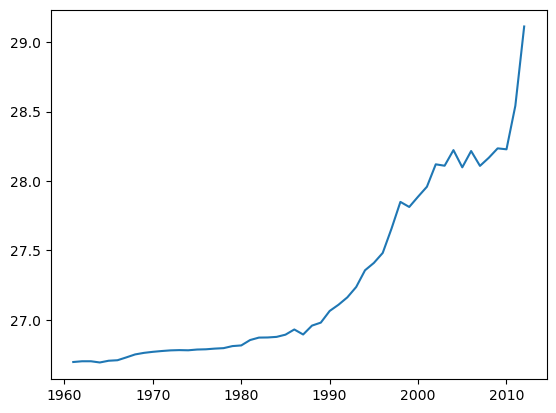

In [10]:
year_list = []
MSE_list = []
for year in range(int(lego_mod_df.Year_released.min()),int(lego_mod_df.Year_released.max())-10):
    lego_mod_postdate_df = lego_mod_df[lego_mod_df.Year_released >= year]
    y_new = lego_mod_postdate_df.Price
    X_new = lego_mod_postdate_df.drop(['Price'], axis=1)


    scaler  = preprocessing.StandardScaler()
    polyn = preprocessing.PolynomialFeatures(2) 

    numerical_transformer = Pipeline(steps=[
        ('scale', scaler),
        ('poly', polyn)
    ])
    print(year)
    preprocessor = ColumnTransformer(
        transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),

        ],
    remainder = 'drop'
    )

    year_list.append(year)
    MSE_list.append(linear_model(preprocessor,X_new,y_new))
plt.plot(year_list, MSE_list)

We see that the more data the more accurate the model.

In [46]:
#Last time I'll define the numerical transformer, for now.
scaler  = preprocessing.StandardScaler()
polyn = preprocessing.PolynomialFeatures(2) 
numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])



preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


27.968616471809487

In [72]:
#Last time I'll define the numerical transformer, for now.
scaler  = preprocessing.StandardScaler()
polyn = preprocessing.PolynomialFeatures(2) 
numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])

full_numerical_transformer = ('num', numerical_transformer, ['Pieces','Minifigs','Year_released'])

preprocessor = ColumnTransformer(
    transformers=[full_numerical_transformer
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

27.968616471809487

#### Categorical Data
Next we will look at the categorical data.

Some of these features have many unique variables, whereas some have few, as such I will test to see which are better candidates for onehot, binary and target encoding. Below is a function which tests a given feature's test RMSE and outputs which type of encoding lowers the RMSE

In [73]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder
def cat_tester(feat,full_numerical_transformer,  X, y):
    BI_categorical_transformer = Pipeline(steps=[
        ('Binary', BinaryEncoder(return_df=True))

    ])
    OH_categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))

    ])

    TAR_categorical_transformer = Pipeline(steps=[
        ('Target', TargetEncoder())

    ])
    Encoder_Array = [OH_categorical_transformer, BI_categorical_transformer, TAR_categorical_transformer]
    Encoder_names = ["OneHot","Binary", "Target",]
    lowest =0
    lowest_name =''
    for i, (encoder,encoderName) in enumerate(zip(Encoder_Array,Encoder_names)):

        preprocessor = ColumnTransformer(
            transformers=[
                        full_numerical_transformer,
                      ('test_cat', encoder, [feat]),

            ],
            remainder = 'drop'
    )

        rmse_score = linear_model(preprocessor,X,y)
        if i==0:
            lowest_name =encoderName
            lowest = rmse_score
        elif lowest > rmse_score:
            lowest_name =encoderName
            lowest = rmse_score
#        print(encoderName+": "+ str(rmse_score))
    return lowest_name, lowest


In [77]:
cat_feats = [ 'Set_type', 'Theme', 'Theme_group', 'Subtheme']
for feat in cat_feats:
    encoder  = cat_tester(feat,full_numerical_transformer,X,y)
    print(feat + ': ' +encoder[0] + ' = ' + str(encoder[1]))

Set_type: Target = 27.967237473854993


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during tr

Theme: OneHot = 23.396881822698045
Theme_group: OneHot = 25.030535205849837


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during tr

Subtheme: Target = 27.425683648526313


The RMSE for no categorical data was  27.968616471809487
The values that just include the the numerical data and a given categorical feature, for the "best" encoding types are given as:

Set_type: Target = 27.967237473854993
Theme: OneHot = 23.396881822698045
Theme_group: OneHot = 25.030535205849837
Subtheme: Target = 27.425683648526313

This shows that including each of these improves on the RMSE

The below run specifies our new best model (this actually excludes subtheme from the model).

In [78]:
#Best Run
OH_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    
])

TAR_categorical_transformer = Pipeline(steps=[
    ('Target', ce.TargetEncoder())
    
])
BI_categorical_transformer = Pipeline(steps=[
    ('Binary', BinaryEncoder(return_df=True))
    
])


preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
       #           ('BI_cat', BI_categorical_transformer, ['Set_type']),
                  ('TAR_cat', TAR_categorical_transformer, ['Subtheme','Set_type']),
                  ('OH_cat', OH_categorical_transformer, ['Theme_group', 'Theme'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during tr

23.15407273148164

Now let's run a prediction on the validation set, training on the full trianing data

In [89]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression(fit_intercept=True))
                             ])
my_pipeline.fit(X, y)
y_preds = my_pipeline.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_preds))

19.049360526801557

Not a bad result, my nex